## Final project: Stock Price Analysis & Prediction

**Before we go into the codes, here is an overview of the key steps of this analysis project**

 - Load data from yfinance, create calculated metrics (technical indicators) from the basic dataset to aid our model for better prediction 
 - Setting up model and evaluate: 
     - Model 1: use xgboost to build prediction model on returns and evaluate its performance
     - Model 2: use fbprophet to predict future prices and evaluate its performance
     - Model 3: use xgbclassifier to predict next 30 days performance 
 - Visualize this through streamlit (only Model 2 at this point)

**Section 1: Loading data & adding metrics**

In [1]:
import yfinance as yf
import plotly.express as px
from prophet import Prophet
from datetime import date
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
import plotly.offline as off
pd.options.plotting.backend = "plotly"
off.init_notebook_mode()

In [2]:
start = '2010-01-01'
today = date.today().strftime('%Y-%m-%d')

In [3]:
def load_data(ticker):
    df = yf.download(ticker, start, today).reset_index()
    return df

In [4]:
df = load_data('MSFT')

[*********************100%***********************]  1 of 1 completed


In [5]:
df.tail()

Date        Open        High         Low       Close   Adj Close  \
3036 2022-01-25  291.519989  294.989990  285.170013  288.489990  288.489990   
3037 2022-01-26  307.989990  308.500000  293.029999  296.709991  296.709991   
3038 2022-01-27  302.660004  307.299988  297.929993  299.839996  299.839996   
3039 2022-01-28  300.230011  308.480011  294.450012  308.260010  308.260010   
3040 2022-01-31  308.950012  312.380005  306.369995  310.980011  310.980011   

        Volume  
3036  72848600  
3037  90428900  
3038  53481300  
3039  49743700  
3040  46444500

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3041 entries, 0 to 3040
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3041 non-null   datetime64[ns]
 1   Open       3041 non-null   float64       
 2   High       3041 non-null   float64       
 3   Low        3041 non-null   float64       
 4   Close      3041 non-null   float64       
 5   Adj Close  3041 non-null   float64       
 6   Volume     3041 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 166.4 KB


In [7]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [8]:
df.describe()

Open         High          Low        Close    Adj Close  \
count  3041.000000  3041.000000  3041.000000  3041.000000  3041.000000   
mean     87.526383    88.337119    86.679073    87.554781    83.273166   
std      78.103058    78.851953    77.302662    78.120903    79.499918   
min      23.090000    23.320000    22.730000    23.010000    17.936007   
25%      30.930000    31.180000    30.650000    30.950001    25.338295   
50%      51.779999    52.200001    51.090000    51.779999    47.194557   
75%     111.660004   112.239998   110.639999   111.709999   107.789299   
max     344.619995   349.670013   342.200012   343.109985   343.109985   

             Volume  
count  3.041000e+03  
mean   3.863369e+07  
std    2.198865e+07  
min    7.425600e+06  
25%    2.392570e+07  
50%    3.286020e+07  
75%    4.824450e+07  
max    3.193179e+08

In [9]:
#check out closing price distribution
fig = px.histogram(df, x="Adj Close")
fig.show()

In [10]:
df['Close_log'] = np.log(df['Close'])

In [11]:
df['FwdRet1']   = df['Close_log'].shift(-1)   - df['Close_log']
df['FwdRet5']   = df['Close_log'].shift(-5)   - df['Close_log']
df['FwdRet30']  = df['Close_log'].shift(-30)  - df['Close_log']
df['FwdRet126'] = df['Close_log'].shift(-126) - df['Close_log']
df['FwdRet252'] = df['Close_log'].shift(-252) - df['Close_log']

In [12]:
avgs = [5, 10, 30, 126, 252]
for avg in avgs:
    df[f'sma-{avg}-rat'] = df['Close'].rolling(avg).mean() / df['Close']
    df[f'vol-{avg}-chg'] = df['Volume'].pct_change(avg)

In [13]:
df['Volatility'] = ((df['High'] - df['Low']) / df['Close']).pct_change()

In [14]:
fwd_rets = [1, 5, 30, 126, 252]

for ret in fwd_rets:
    for i in range(1, 3):
        df[f'FwdRet{ret}-shft-{i}'] = df[f'FwdRet{ret}'].shift(i)

In [15]:
df.head()

Date       Open       High        Low      Close  Adj Close    Volume  \
0 2010-01-04  30.620001  31.100000  30.590000  30.950001  23.904982  38409100   
1 2010-01-05  30.850000  31.100000  30.639999  30.959999  23.912708  49749600   
2 2010-01-06  30.879999  31.080000  30.520000  30.770000  23.765961  58182400   
3 2010-01-07  30.629999  30.700001  30.190001  30.450001  23.518795  50559700   
4 2010-01-08  30.280001  30.879999  30.240000  30.660000  23.680994  51197400   

   Close_log   FwdRet1   FwdRet5  ...  FwdRet1-shft-1  FwdRet1-shft-2  \
0   3.432373  0.000323 -0.022216  ...             NaN             NaN   
1   3.432696 -0.006156 -0.029168  ...        0.000323             NaN   
2   3.426540 -0.010454 -0.013744  ...       -0.006156        0.000323   
3   3.416086  0.006873  0.016610  ...       -0.010454       -0.006156   
4   3.422959 -0.012802  0.006502  ...        0.006873       -0.010454   

   FwdRet5-shft-1  FwdRet5-shft-2  FwdRet30-shft-1  FwdRet30-shft-2  \
0             NaN             NaN              NaN              NaN   
1       -0.022216             NaN        -0.079316              NaN   
2       -0.029168       -0.022216        -0.066435        -0.079316   
3       -0.013744       -0.029168        -0.067207        -0.066435   
4        0.016610       -0.013744        -0.058144        -0.067207   

   FwdRet126-shft-1  FwdRet126-shft-2  FwdRet252-shft-1  FwdRet252-shft-2  
0               NaN               NaN               NaN               NaN  
1         -0.261847               NaN         -0.100883               NaN  
2         -0.242220         -0.261847         -0.097282         -0.100883  
3         -0.231547         -0.242220         -0.094336         -0.097282  
4         -0.226845         -0.231547         -0.055016         -0.094336  

[5 rows x 34 columns]

In [16]:
#create time series variables! here we would like start with 20, 50, and 200 SMA 
df['SMA_20_ratio'] = df['Close'].rolling(20).mean().shift().bfill()/df['Close']
df['SMA_50_ratio'] = df['Close'].rolling(50).mean().shift().bfill()/df['Close']
df['SMA_200_ratio'] = df['Close'].rolling(200).mean().shift().bfill()/df['Close']

In [17]:
df.head()

Date       Open       High        Low      Close  Adj Close    Volume  \
0 2010-01-04  30.620001  31.100000  30.590000  30.950001  23.904982  38409100   
1 2010-01-05  30.850000  31.100000  30.639999  30.959999  23.912708  49749600   
2 2010-01-06  30.879999  31.080000  30.520000  30.770000  23.765961  58182400   
3 2010-01-07  30.629999  30.700001  30.190001  30.450001  23.518795  50559700   
4 2010-01-08  30.280001  30.879999  30.240000  30.660000  23.680994  51197400   

   Close_log   FwdRet1   FwdRet5  ...  FwdRet5-shft-2  FwdRet30-shft-1  \
0   3.432373  0.000323 -0.022216  ...             NaN              NaN   
1   3.432696 -0.006156 -0.029168  ...             NaN        -0.079316   
2   3.426540 -0.010454 -0.013744  ...       -0.022216        -0.066435   
3   3.416086  0.006873  0.016610  ...       -0.029168        -0.067207   
4   3.422959 -0.012802  0.006502  ...       -0.013744        -0.058144   

   FwdRet30-shft-2  FwdRet126-shft-1  FwdRet126-shft-2  FwdRet252-shft-1  \
0              NaN               NaN               NaN               NaN   
1              NaN         -0.261847               NaN         -0.100883   
2        -0.079316         -0.242220         -0.261847         -0.097282   
3        -0.066435         -0.231547         -0.242220         -0.094336   
4        -0.067207         -0.226845         -0.231547         -0.055016   

   FwdRet252-shft-2  SMA_20_ratio  SMA_50_ratio  SMA_200_ratio  
0               NaN      0.971244      0.942313       0.877415  
1               NaN      0.970930      0.942009       0.877132  
2         -0.100883      0.976926      0.947826       0.882548  
3         -0.097282      0.987192      0.957787       0.891823  
4         -0.094336      0.980431      0.951226       0.885714  

[5 rows x 37 columns]

In [18]:
#adding additional time variables based on date
df['dow']  = df['Date'].dt.dayofweek
df['month']   = df['Date'].dt.month
df['year']   = df['Date'].dt.year
df['day']   = df['Date'].dt.day
df['week']   = df['Date'].dt.week

<ipython-input-18-15fc791eda50>:6: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [19]:
len(df['Close'])

3041

In [20]:
#also adding ema variables in case we will need this
def cal_ema(prices, days, smoothing = 2):
    ema = []
    for price in prices [:days]:
        ema.append(sum(prices[:days]) / days)
    for price in prices[days:]:
        ema.append((price * (smoothing / (1 + days))) + ema[-1] * (1 - (smoothing / (1 + days))))
    return ema

In [21]:
test = cal_ema(df['Close'],12,smoothing = 2)
len(test) 

#just a test to make sure the returned ema value fits the same length as original df

3041

In [22]:
#adding EMA metrics to the dataset!
df['EMA_12_ratio'] = cal_ema(df['Close'],12,smoothing = 2)/df['Close']
df['EMA_26_ratio'] = cal_ema(df['Close'],26,smoothing = 2)/df['Close']

In [23]:
#building a graph to observe stock price, EMA_20 (for short term) and SMA_200 (for long term)
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='stock price',
                         line=dict(width=4)))
fig2.add_trace(go.Scatter(x=df['Date'], y=df['EMA_26_ratio']*df['Close'], name='EMA_26',
                         line=dict(width=2)))
fig2.add_trace(go.Scatter(x=df['Date'], y=df['SMA_200_ratio']*df['Close'], name='SMA_200',
                         line=dict(width=2)))

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3041 entries, 0 to 3040
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              3041 non-null   datetime64[ns]
 1   Open              3041 non-null   float64       
 2   High              3041 non-null   float64       
 3   Low               3041 non-null   float64       
 4   Close             3041 non-null   float64       
 5   Adj Close         3041 non-null   float64       
 6   Volume            3041 non-null   int64         
 7   Close_log         3041 non-null   float64       
 8   FwdRet1           3040 non-null   float64       
 9   FwdRet5           3036 non-null   float64       
 10  FwdRet30          3011 non-null   float64       
 11  FwdRet126         2915 non-null   float64       
 12  FwdRet252         2789 non-null   float64       
 13  sma-5-rat         3037 non-null   float64       
 14  vol-5-chg         3036 n

In [25]:
#select columns that are relavent as input for the model
thirty_cols = ['FwdRet30', 'sma-5-rat', 'Volatility',
       'vol-5-chg', 'sma-10-rat', 'vol-10-chg', 'sma-30-rat', 'vol-30-chg',
       'sma-126-rat', 'vol-126-chg', 'sma-252-rat', 'vol-252-chg', 'FwdRet1-shft-1', 'FwdRet1-shft-2', 'FwdRet5-shft-1',
       'FwdRet5-shft-2', 'FwdRet30-shft-1', 'FwdRet30-shft-2',
       'FwdRet126-shft-1', 'FwdRet126-shft-2', 'FwdRet252-shft-1','SMA_20_ratio','SMA_50_ratio','SMA_200_ratio', 'EMA_12_ratio','EMA_26_ratio',
       'FwdRet252-shft-2','dow','day','month','year','week']

df30 = df[thirty_cols]

In [26]:
fig3 = go.Figure()
fig3.add_trace(go.Bar(x=df30['dow'], y=df30.groupby('dow')['FwdRet30'].mean()))
#Day of week doesn't not trigger significant difference in our exploratory analysis

In [27]:
df30.groupby('month')['FwdRet30'].mean().plot(kind = 'bar', title = 'Mean by Month')
#March, June, September, and Oct historical tend to perform better than other months

In [28]:
df30.groupby('day')['FwdRet30'].mean().plot(kind = 'line', title = 'Mean by day of month')

In [29]:
df30.corr(method = 'spearman')
#check correlation

FwdRet30  sma-5-rat  Volatility  vol-5-chg  sma-10-rat  \
FwdRet30          1.000000   0.076706   -0.001858  -0.009195    0.093492   
sma-5-rat         0.076706   1.000000    0.047030   0.094767    0.827185   
Volatility       -0.001858   0.047030    1.000000   0.185688    0.020191   
vol-5-chg        -0.009195   0.094767    0.185688   1.000000    0.070771   
sma-10-rat        0.093492   0.827185    0.020191   0.070771    1.000000   
vol-10-chg       -0.021975   0.061938    0.162690   0.502897    0.082601   
sma-30-rat        0.120435   0.492466    0.001879   0.018230    0.708264   
vol-30-chg       -0.014687   0.089603    0.164246   0.453249    0.120172   
sma-126-rat       0.194123   0.253962    0.005832   0.006777    0.371216   
vol-126-chg       0.029777   0.050079    0.136659   0.382202    0.073798   
sma-252-rat       0.131181   0.218516    0.006404   0.005023    0.317544   
vol-252-chg      -0.004347   0.059270    0.136870   0.326993    0.085914   
FwdRet1-shft-1   -0.046129  -0.681948   -0.031525  -0.046711   -0.475977   
FwdRet1-shft-2   -0.037148  -0.478470   -0.071758  -0.067036   -0.404349   
FwdRet5-shft-1    0.268862  -0.233539   -0.020138  -0.010860   -0.130894   
FwdRet5-shft-2    0.181773  -0.492025   -0.051091  -0.048896   -0.351323   
FwdRet30-shft-1   0.943803  -0.074031   -0.019580  -0.024953   -0.015022   
FwdRet30-shft-2   0.897203  -0.180472   -0.022253  -0.039178   -0.106577   
FwdRet126-shft-1  0.428513  -0.040588   -0.008707  -0.010303    0.014299   
FwdRet126-shft-2  0.419019  -0.110219   -0.015390  -0.022193   -0.045248   
FwdRet252-shft-1  0.353350  -0.032125   -0.011501  -0.005535    0.000416   
SMA_20_ratio      0.107021   0.592436    0.005516   0.029845    0.828605   
SMA_50_ratio      0.149708   0.381225    0.002825   0.009871    0.556265   
SMA_200_ratio     0.144950   0.225869    0.004979   0.004292    0.327629   
EMA_12_ratio      0.105061   0.800165    0.020054   0.056713    0.958598   
EMA_26_ratio      0.136184   0.589038    0.008377   0.027309    0.793463   
FwdRet252-shft-2  0.350197  -0.082671   -0.015475  -0.012856   -0.040056   
dow               0.001978   0.001747    0.025729   0.019115   -0.007820   
day              -0.023684  -0.007723   -0.004128   0.041046   -0.022032   
month            -0.002604  -0.008713   -0.011294  -0.072608   -0.019156   
year              0.228517  -0.074351   -0.002855   0.009930   -0.103584   
week             -0.002126  -0.014182   -0.012445  -0.057199   -0.023600   

                  vol-10-chg  sma-30-rat  vol-30-chg  sma-126-rat  \
FwdRet30           -0.021975    0.120435   -0.014687     0.194123   
sma-5-rat           0.061938    0.492466    0.089603     0.253962   
Volatility          0.162690    0.001879    0.164246     0.005832   
vol-5-chg           0.502897    0.018230    0.453249     0.006777   
sma-10-rat          0.082601    0.708264    0.120172     0.371216   
vol-10-chg          1.000000    0.031072    0.457320    -0.009150   
sma-30-rat          0.031072    1.000000    0.155262     0.652089   
vol-30-chg          0.457320    0.155262    1.000000     0.035304   
sma-126-rat        -0.009150    0.652089    0.035304     1.000000   
vol-126-chg         0.376541    0.127621    0.423013     0.145578   
sma-252-rat        -0.005750    0.543662    0.043512     0.895078   
vol-252-chg         0.345326    0.135707    0.399691     0.061567   
FwdRet1-shft-1     -0.031954   -0.276011   -0.044992    -0.147248   
FwdRet1-shft-2     -0.030316   -0.255041   -0.053840    -0.133212   
FwdRet5-shft-1     -0.014558   -0.041142   -0.028235     0.023765   
FwdRet5-shft-2     -0.029633   -0.182597   -0.045734    -0.058904   
FwdRet30-shft-1    -0.031766    0.057367   -0.019911     0.154765   
FwdRet30-shft-2    -0.039898   -0.000432   -0.029916     0.120844   
FwdRet126-shft-1   -0.006657    0.094942    0.009101     0.122210   
FwdRet126-shft-2   -0.014189    0.055557    0.001729     0.104141   
FwdRet252-shft-1   -0.012096    0.052402   -0.007842     0.0

**Section 2: Modelling**

a. XGBOOST

In [30]:
#Notes for myself:
# drop('Open', 'High', 'Low', 'Close', 'Adj Close') as they have a natural tendency to move up and thus may shadow actual signals
# df['SMA_20'] / df['Close'] to get ratios. (same for EMAs)
# Volume is important as it predicts larger price signal. df['Volume'].pct_change(), df['Volume'].pct_change(10), df['Volume'].pct_change(30)
# IMPT: for time series data, we would want to remove serial correlations and look at stationary metrics
# for log we look at diff(), for abs values we look at pct_change
# it's also helpful to look at multiple different time horizens, such as 1D, 5D, 30D, 126D, 252D etc

In [31]:
df30 = df30.dropna()

In [32]:
#note can't do random split to avoid data spillage given this is a time series
def split_data(df, perc):
    X  = df.drop('FwdRet30', axis=1)
    y  = df['FwdRet30']
    
    return train_test_split(X, y, test_size = perc, shuffle = False)

In [33]:
def get_model_score(mod, X_train, y_train, X_test, y_test, val_score = True, test_score = False):
    if val_score:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, shuffle = False)
        mod.fit(X_train, y_train)
        results = {}
        results['train_score'] = mod.score (X_train, y_train)
        results['val_score'] = mod.score (X_val, y_val)
    if test_score: 
        results['test_score'] = mod.score (X_test, y_test)
        
    return results

In [34]:
def get_feature_importances(mod, X_train):
    return pd.DataFrame({
        'Col': X_train.columns,
        'Importance': mod.feature_importances_
    }).sort_values(by='Importance', ascending=False)

In [35]:
import xgboost as xgb

In [36]:
mod = xgb.XGBRegressor(colsample_bytree = 0.5)

In [37]:
X_train, X_test, y_train, y_test = split_data(df30, 0.2)

In [38]:
X_train.shape

(2030, 31)

In [39]:
scores = get_model_score(mod, X_train, y_train, X_test, y_test, test_score = True)

In [40]:
scores
#the val score and test score are ok- although there is obvious overfitting on the training set 

{'train_score': 0.9996581558667387,
 'val_score': 0.7584272579093774,
 'test_score': 0.7507326282626805}

In [41]:
feats = get_feature_importances(mod, X_train)
feats
#FwdRet values are dominating in importance

Col  Importance
16   FwdRet30-shft-2    0.324230
15   FwdRet30-shft-1    0.305545
18  FwdRet126-shft-2    0.105820
22     SMA_200_ratio    0.063214
17  FwdRet126-shft-1    0.042874
7        sma-126-rat    0.026100
30              week    0.025984
11    FwdRet1-shft-1    0.018434
25  FwdRet252-shft-2    0.011185
24      EMA_26_ratio    0.010710
0          sma-5-rat    0.008548
5         sma-30-rat    0.006497
28             month    0.005497
9        sma-252-rat    0.005407
13    FwdRet5-shft-1    0.004095
19  FwdRet252-shft-1    0.003987
12    FwdRet1-shft-2    0.003554
27               day    0.003207
6         vol-30-chg    0.002924
20      SMA_20_ratio    0.002904
14    FwdRet5-shft-2    0.002838
10       vol-252-chg    0.002311
23      EMA_12_ratio    0.002300
8        vol-126-chg    0.002013
3         sma-10-rat    0.001881
2          vol-5-chg    0.001732
29              year    0.001636
4         vol-10-chg    0.001528
1         Volatility    0.001223
26               dow    0.000952
21      SMA_50_ratio    0.000869

In [42]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, mod.predict(X_test), squared = False)
#it also has a reasonable MAPE value

0.03597426029608565

Now we fine-tune the model by optimizing the parameters

In [43]:
max_depth = [3,4,5, 6]
max_features = [0.6, 0.8, 1]
learning_rate = [0.05, 0.1, 0.2]
n_estimators = [50, 100, 200, 300, 400]
cv_scores = []

In [44]:
for depth in max_depth:
    for feature in max_features:
        for rate in learning_rate:
            for estimator in n_estimators:
                print(f"Getting validation score for: depth: {depth}, max_features: {feature}, learning_rate: {rate}, n_estimators: {estimator}")
                
                mod.set_params(max_depth = depth, max_features = feature, learning_rate = rate, n_estimators = estimator)
                test_score = get_model_score(mod, X_train, y_train, X_test, y_test)
                cv_scores.append((test_score['train_score'], test_score['val_score'], depth, feature, rate, estimator))

Getting validation score for: depth: 3, max_features: 0.6, learning_rate: 0.05, n_estimators: 50
[22:30:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:30:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Getting validation score for: depth: 3, max_features: 0.6, learning_rate: 0.05, n_estimators: 100
[22:30:00] WARN

Getting validation score for: depth: 3, max_features: 0.6, learning_rate: 0.2, n_estimators: 50
[22:30:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:30:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Getting validation score for: depth: 3, max_features: 0.6, learning_rate: 0.2, n_estimators: 100
[22:30:10] WARNIN

Getting validation score for: depth: 3, max_features: 0.8, learning_rate: 0.1, n_estimators: 50
[22:30:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:30:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Getting validation score for: depth: 3, max_features: 0.8, learning_rate: 0.1, n_estimators: 100
[22:30:22] WARNIN

Getting validation score for: depth: 3, max_features: 1, learning_rate: 0.05, n_estimators: 50
[22:30:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:30:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Getting validation score for: depth: 3, max_features: 1, learning_rate: 0.05, n_estimators: 100
[22:30:33] WARNING:

Getting validation score for: depth: 3, max_features: 1, learning_rate: 0.2, n_estimators: 50
[22:30:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:30:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Getting validation score for: depth: 3, max_features: 1, learning_rate: 0.2, n_estimators: 100
[22:30:43] WARNING: /

Getting validation score for: depth: 4, max_features: 0.6, learning_rate: 0.1, n_estimators: 50
[22:30:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:30:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Getting validation score for: depth: 4, max_features: 0.6, learning_rate: 0.1, n_estimators: 100
[22:30:56] WARNIN

Getting validation score for: depth: 4, max_features: 0.8, learning_rate: 0.05, n_estimators: 50
[22:31:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:31:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Getting validation score for: depth: 4, max_features: 0.8, learning_rate: 0.05, n_estimators: 100
[22:31:10] WARN

Getting validation score for: depth: 4, max_features: 0.8, learning_rate: 0.2, n_estimators: 50
[22:31:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:31:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Getting validation score for: depth: 4, max_features: 0.8, learning_rate: 0.2, n_estimators: 100
[22:31:24] WARNIN

Getting validation score for: depth: 4, max_features: 1, learning_rate: 0.1, n_estimators: 50
[22:31:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:31:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Getting validation score for: depth: 4, max_features: 1, learning_rate: 0.1, n_estimators: 100
[22:31:38] WARNING: /

Getting validation score for: depth: 5, max_features: 0.6, learning_rate: 0.05, n_estimators: 50
[22:31:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:31:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Getting validation score for: depth: 5, max_features: 0.6, learning_rate: 0.05, n_estimators: 100
[22:31:52] WARN

Getting validation score for: depth: 5, max_features: 0.6, learning_rate: 0.2, n_estimators: 50
[22:32:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:32:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Getting validation score for: depth: 5, max_features: 0.6, learning_rate: 0.2, n_estimators: 100
[22:32:12] WARNIN

Getting validation score for: depth: 5, max_features: 0.8, learning_rate: 0.1, n_estimators: 50
[22:32:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:32:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Getting validation score for: depth: 5, max_features: 0.8, learning_rate: 0.1, n_estimators: 100
[22:32:30] WARNIN

Getting validation score for: depth: 5, max_features: 1, learning_rate: 0.05, n_estimators: 50
[22:32:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:32:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Getting validation score for: depth: 5, max_features: 1, learning_rate: 0.05, n_estimators: 100
[22:32:47] WARNING:

Getting validation score for: depth: 5, max_features: 1, learning_rate: 0.2, n_estimators: 50
[22:33:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:33:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Getting validation score for: depth: 5, max_features: 1, learning_rate: 0.2, n_estimators: 100
[22:33:07] WARNING: /

Getting validation score for: depth: 6, max_features: 0.6, learning_rate: 0.1, n_estimators: 50
[22:33:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:33:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Getting validation score for: depth: 6, max_features: 0.6, learning_rate: 0.1, n_estimators: 100
[22:33:27] WARNIN

Getting validation score for: depth: 6, max_features: 0.8, learning_rate: 0.05, n_estimators: 50
[22:33:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:33:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Getting validation score for: depth: 6, max_features: 0.8, learning_rate: 0.05, n_estimators: 100
[22:33:45] WARN

Getting validation score for: depth: 6, max_features: 0.8, learning_rate: 0.2, n_estimators: 50
[22:34:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:34:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Getting validation score for: depth: 6, max_features: 0.8, learning_rate: 0.2, n_estimators: 100
[22:34:05] WARNIN

Getting validation score for: depth: 6, max_features: 1, learning_rate: 0.1, n_estimators: 50
[22:34:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:34:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Getting validation score for: depth: 6, max_features: 1, learning_rate: 0.1, n_estimators: 100
[22:34:24] WARNING: /

In [45]:
max(cv_scores, 
    key = lambda x: x[1])

(0.9752451803282963, 0.8724241004052081, 3, 0.6, 0.05, 300)

In [46]:
mod.set_params(max_depth = 3, max_features = 0.6, learning_rate = 0.05, n_estimators = 300)

[22:34:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=3, max_features=0.6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [47]:
get_model_score(mod, X_train, y_train, X_test, y_test, test_score = True)

[22:34:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




{'train_score': 0.9752451803282963,
 'val_score': 0.8724241004052081,
 'test_score': 0.8231431771690725}

In [48]:
# plot the differences
fig_diff = go.Figure()
fig_diff.add_trace(go.Scatter(x = X_test.index, y=mod.predict(X_test), name = 'prediction'))
fig_diff.add_trace(go.Scatter(x = X_test.index, y=y_test, name = 'true value'))
fig_diff.update_layout(title = 'Actual vs. Predicted Price Returns')
#we could see the model is fairly well predicting in most cases, although less accurate when there are huge flucs in market

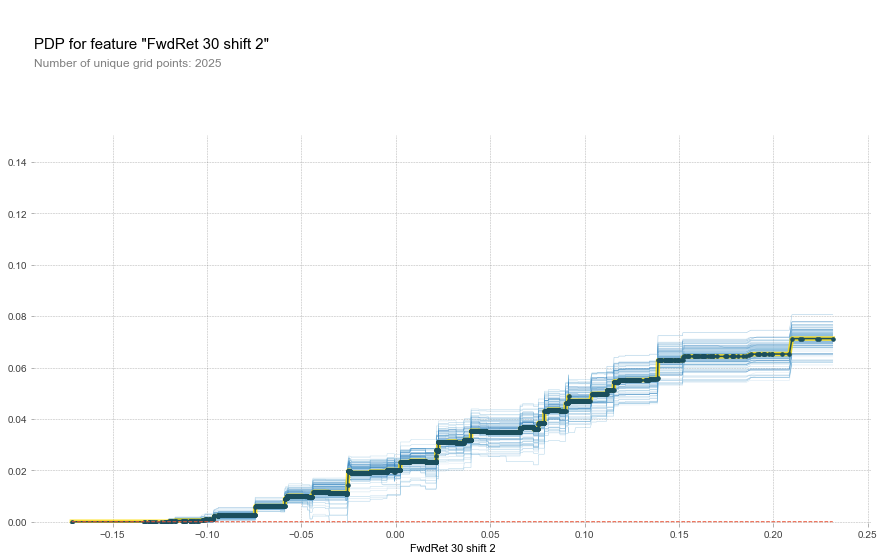

In [50]:
#checking on partial dependency
from pdpbox import pdp, info_plots
pdp_day_of_week = pdp.pdp_isolate(
    model=mod, dataset=X_train, model_features=X_train.columns.tolist(), 
    feature='FwdRet30-shft-2', cust_grid_points = X_train['FwdRet30-shft-2'].unique().tolist()
)

fig, axes = pdp.pdp_plot(pdp_day_of_week, 'FwdRet 30 shift 2', plot_lines=True, frac_to_plot=100)

In [86]:
#NOTE to myself: since it is only trained on MSFT, I won't use this as it most likely won't be accurate in predicting other stocks
import pickle

with open('stockxgb.pkl', 'wb') as export:
    # this creates an external version of the file that we can now import later on
    pickle.dump(mod, export)

In [85]:
X_train.head()

sma-5-rat  Volatility  vol-5-chg  sma-10-rat  vol-10-chg  sma-30-rat  \
252   0.998713   -0.105693   1.468217    1.001287   -0.388910    0.967131   
253   0.995372    0.225947   1.361129    0.998362    0.030194    0.966192   
254   0.998786   -0.247589   2.025187    1.001321    0.546371    0.972000   
255   0.977099    3.007637   3.234864    0.975017    1.083349    0.948624   
256   0.989441   -0.501243   1.980042    0.983566    1.962032    0.959685   

     vol-30-chg  sma-126-rat  vol-126-chg  sma-252-rat  ...  SMA_50_ratio  \
252   -0.101996     0.916020    -0.273782     0.966647  ...      0.955790   
253    0.037815     0.913504    -0.319635     0.962456  ...      0.953870   
254    0.105870     0.917457     0.162350     0.965157  ...      0.958871   
255    0.262162     0.892607     0.635991     0.937472  ...      0.933539   
256    0.298035     0.900519     0.479554     0.944397  ...      0.942762   

     SMA_200_ratio  EMA_12_ratio  EMA_26_ratio  FwdRet252-shft-2  dow  day  \
252       0.947336      0.995691      0.980557         -0.067967    0    3   
253       0.943339      0.993055      0.978441         -0.072428    1    4   
254       0.946102      0.996824      0.982950         -0.044208    2    5   
255       0.918857      0.973314      0.958318         -0.024871    3    6   
256       0.925780      0.983755      0.968231         -0.011494    4    7   

     month  year  week  
252      1  2011     1  
253      1  2011     1  
254      1  2011     1  
255      1  2011     1  
256      1  2011     1  

[5 rows x 31 columns]

**b. FB Prophet**

Having learned through online research that FBprophet is a package suitable for time series analysis, I decided to also try it out for this dataset

In [51]:
prophet_data = df[['Date', 'Close']].rename(columns = {'Date':'ds','Close':'y' })

In [52]:
prophet_data.head()

ds          y
0 2010-01-04  30.950001
1 2010-01-05  30.959999
2 2010-01-06  30.770000
3 2010-01-07  30.450001
4 2010-01-08  30.660000

In [53]:
prophet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3041 entries, 0 to 3040
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3041 non-null   datetime64[ns]
 1   y       3041 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 47.6 KB


In [54]:
fbp = Prophet(daily_seasonality = True)

In [55]:
fbp.fit(prophet_data)

In [56]:
fut = fbp.make_future_dataframe(periods=365) 
forecast = fbp.predict(fut)
#would like to predict the next 365 days
forecast.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2010-01-04  30.898918   21.996872   38.512968    30.898918    30.898918   
1 2010-01-05  30.879632   22.305012   37.724702    30.879632    30.879632   
2 2010-01-06  30.860345   21.919875   37.737177    30.860345    30.860345   
3 2010-01-07  30.841058   20.934101   37.383862    30.841058    30.841058   
4 2010-01-08  30.821772   20.919790   37.211606    30.821772    30.821772   

   additive_terms  additive_terms_lower  additive_terms_upper     daily  ...  \
0       -0.722835             -0.722835             -0.722835 -0.070312  ...   
1       -0.937913             -0.937913             -0.937913 -0.070312  ...   
2       -1.164979             -1.164979             -1.164979 -0.070312  ...   
3       -1.408903             -1.408903             -1.408903 -0.070312  ...   
4       -1.544934             -1.544934             -1.544934 -0.070312  ...   

     weekly  weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0 -0.036941     -0.036941     -0.036941 -0.615582     -0.615582     -0.615582   
1 -0.017080     -0.017080     -0.017080 -0.850521     -0.850521     -0.850521   
2 -0.009152     -0.009152     -0.009152 -1.085514     -1.085514     -1.085514   
3 -0.021512     -0.021512     -0.021512 -1.317079     -1.317079     -1.317079   
4  0.067107      0.067107      0.067107 -1.541729     -1.541729     -1.541729   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper       yhat  
0                         0.0  30.176083  
1                         0.0  29.941719  
2                         0.0  29.695367  
3                         0.0  29.432155  
4                         0.0  29.276838  

[5 rows x 22 columns]

In [57]:
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(fbp, forecast)
#from this plot we see that fbprophet is good with predicting overall trend, but can't really account for short term fluctuations such as Black Swan events where there is large fluctuations (i.e look at march 2020 and most recently Jan 2022)

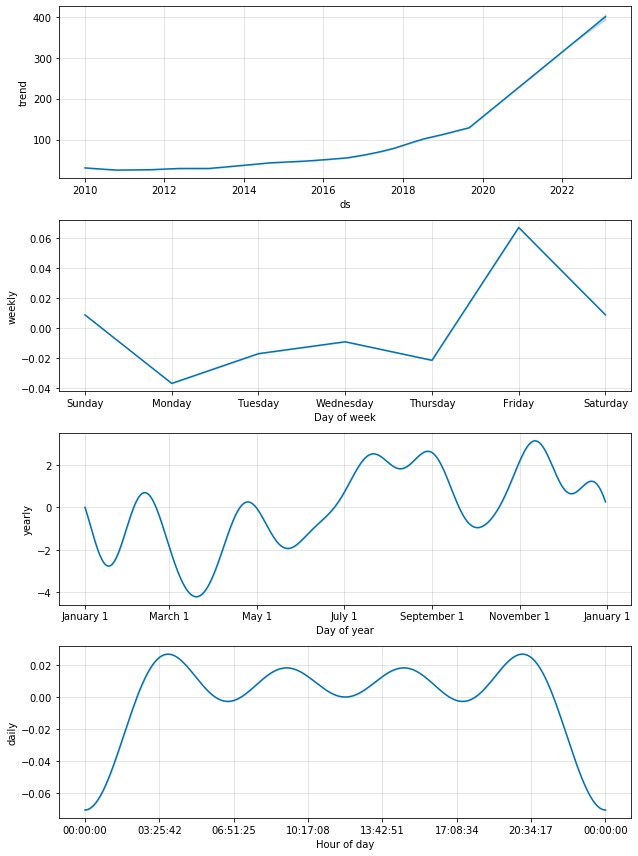

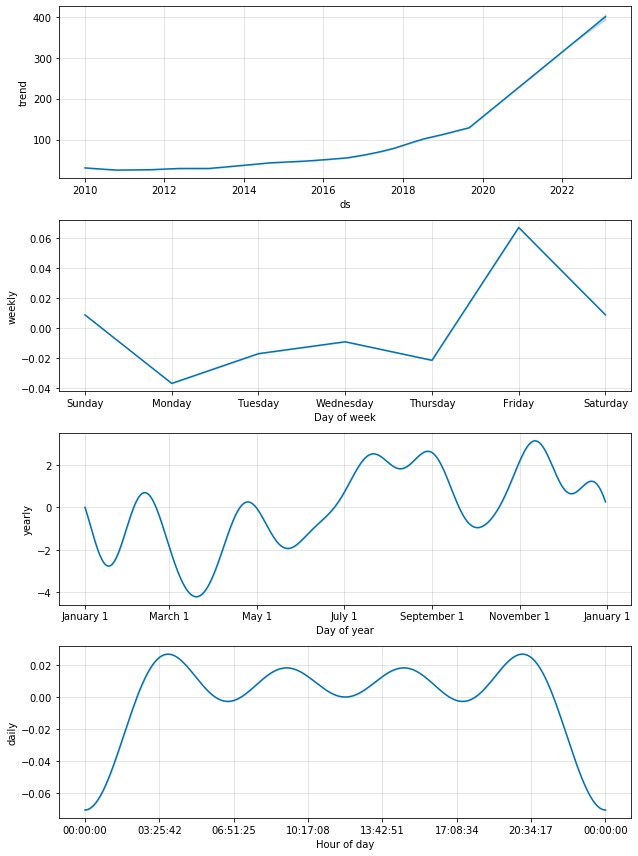

In [58]:
fbp.plot_components(forecast)

In [59]:
#cross validation step
from prophet.diagnostics import cross_validation
prophet_cv = cross_validation(fbp, initial='1430 days', period='180 days', horizon = '365 days')

#By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.

INFO:prophet:Making 15 forecasts with cutoffs between 2014-03-09 00:00:00 and 2021-01-31 00:00:00


  0%|          | 0/15 [00:00<?, ?it/s]

In [60]:
prophet_cv

ds        yhat  yhat_lower  yhat_upper           y     cutoff
0    2014-03-10   38.775331   37.208006   40.358490   37.820000 2014-03-09
1    2014-03-11   38.820439   37.259012   40.295228   38.020000 2014-03-09
2    2014-03-12   38.849434   37.333106   40.423287   38.270000 2014-03-09
3    2014-03-13   38.919844   37.401695   40.494753   37.889999 2014-03-09
4    2014-03-14   38.959462   37.481578   40.444539   37.700001 2014-03-09
...         ...         ...         ...         ...         ...        ...
3771 2022-01-25  280.338985  269.356303  292.293754  288.489990 2021-01-31
3772 2022-01-26  280.575593  269.319911  291.869134  296.709991 2021-01-31
3773 2022-01-27  280.774390  269.011389  293.134581  299.839996 2021-01-31
3774 2022-01-28  280.929454  269.782828  292.539544  308.260010 2021-01-31
3775 2022-01-31  281.447567  269.984581  293.451373  310.980011 2021-01-31

[3776 rows x 6 columns]

In [61]:
#now look at performance metrics
from fbprophet.diagnostics import performance_metrics
prophet_p = performance_metrics(prophet_cv)
prophet_p

horizon         mse       rmse        mae      mape     mdape  coverage
0    37 days  109.302237  10.454771   6.527174  0.059316  0.043667  0.335664
1    38 days  106.300576  10.310217   6.419985  0.058572  0.043584  0.346274
2    39 days  104.519044  10.223456   6.340235  0.058117  0.043055  0.354377
3    40 days  101.586778  10.079027   6.280134  0.058081  0.043055  0.350374
4    41 days   99.814014   9.990696   6.269536  0.058382  0.043055  0.343381
..       ...         ...        ...        ...       ...       ...       ...
324 361 days  684.304874  26.159222  19.793135  0.144772  0.148953  0.296600
325 362 days  681.531292  26.106154  19.724099  0.144643  0.148390  0.301905
326 363 days  691.625386  26.298772  19.848148  0.144874  0.148390  0.303979
327 364 days  703.967597  26.532388  20.026413  0.145941  0.149416  0.304377
328 365 days  717.242367  26.781381  20.231030  0.146656  0.151143  0.303183

[329 rows x 7 columns]

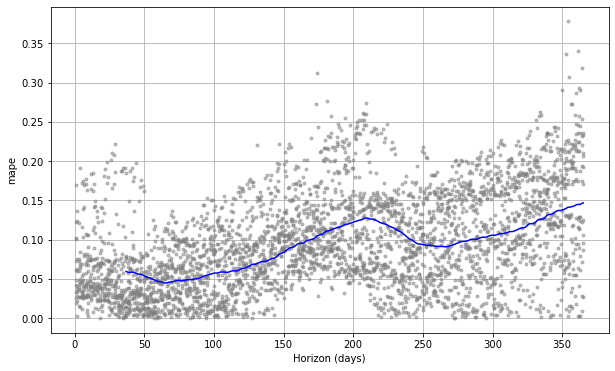

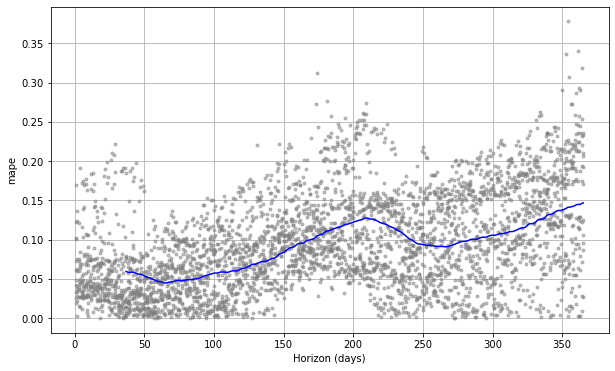

In [62]:
from fbprophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(prophet_cv, metric = 'mape')

**3. Classification**

Starting simple to predict if it's an unusually good month, a non-eventful month, or a losing month

In [63]:
conditions = [
    df['FwdRet30'] >= df['FwdRet30'].quantile(.8), 
    df['FwdRet30'] > 0
]

results = [
    1, 0
]

df['Target30'] = np.select(conditions, results, -1)

In [64]:
class_cols = ['Target30', 'sma-5-rat', 'Volatility',
       'vol-5-chg', 'sma-10-rat', 'vol-10-chg', 'sma-30-rat', 'vol-30-chg',
       'sma-126-rat', 'vol-126-chg', 'sma-252-rat', 'vol-252-chg', 'FwdRet1-shft-1', 'FwdRet1-shft-2', 'FwdRet5-shft-1',
       'FwdRet5-shft-2', 'FwdRet30-shft-1', 'FwdRet30-shft-2',
       'FwdRet126-shft-1', 'FwdRet126-shft-2', 'FwdRet252-shft-1','SMA_20_ratio','SMA_50_ratio','SMA_200_ratio', 'EMA_12_ratio','EMA_26_ratio',
       'FwdRet252-shft-2','dow','day','month','year','week']

df_class = df[class_cols]

In [65]:
from xgboost import XGBClassifier
mod2  = XGBClassifier(eval_metric = 'logloss', colsample_bytree = 0.5)

In [66]:
def split_data_class(df, perc):
    X  = df.drop('Target30', axis=1)
    y  = df['Target30']
    
    return train_test_split(X, y, test_size = perc, shuffle = False)

In [67]:
X_train2, X_test2, y_train2, y_test2 = split_data_class(df_class, 0.2)

In [68]:
def get_model_score_class(mod, X_train, y_train, X_test, y_test, val_score = True, test_score = False):
    if val_score:
        X_train, X_val, y_train, y_val = split_data_class(df_class[:round(len(X_train))], 0.2)
        mod.fit(X_train, y_train)
        results = {}
        results['train_score'] = mod.score (X_train, y_train)
        results['val_score'] = mod.score (X_val, y_val)
    if test_score: 
        results['test_score'] = mod.score (X_test, y_test)
        
    return results

In [69]:
scores2 = get_model_score_class(mod2, X_train2, y_train2, X_test2, y_test2, test_score = True)

In [70]:
scores2
# we have a reasonable val_score and test_score, but there is still risk of over-fitting judging by the difference in training score vs. the other two

{'train_score': 1.0,
 'val_score': 0.8357289527720739,
 'test_score': 0.8423645320197044}

In [71]:
feats2 = get_feature_importances(mod2, X_train2)
feats2

Col  Importance
15   FwdRet30-shft-1    0.214122
16   FwdRet30-shft-2    0.128443
30              week    0.063366
25  FwdRet252-shft-2    0.061419
18  FwdRet126-shft-2    0.057545
22     SMA_200_ratio    0.038320
11    FwdRet1-shft-1    0.033689
5         sma-30-rat    0.032060
28             month    0.028524
9        sma-252-rat    0.027305
24      EMA_26_ratio    0.026403
0          sma-5-rat    0.024340
13    FwdRet5-shft-1    0.022491
7        sma-126-rat    0.021478
3         sma-10-rat    0.020545
19  FwdRet252-shft-1    0.017738
17  FwdRet126-shft-1    0.016777
23      EMA_12_ratio    0.016530
2          vol-5-chg    0.014978
10       vol-252-chg    0.014629
20      SMA_20_ratio    0.014205
14    FwdRet5-shft-2    0.013159
6         vol-30-chg    0.012574
4         vol-10-chg    0.011431
27               day    0.011418
29              year    0.010302
12    FwdRet1-shft-2    0.010302
1         Volatility    0.010225
26               dow    0.009347
8        vol-126-chg    0.009284
21      SMA_50_ratio    0.007049

In [72]:
from sklearn.metrics import accuracy_score
y_predict = mod2.predict(X_test2)
accuracy_score(y_test2, y_predict)
#there is 84% accuracy in our model, much better than blind guess (50%)

0.8423645320197044

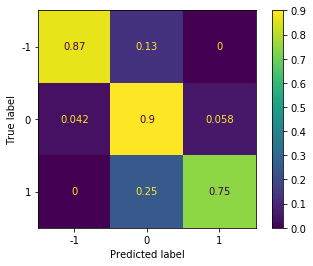

In [73]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(mod2, X_test2, y_test2, normalize = 'true')

In [74]:
from sklearn.metrics import classification_report
print(classification_report(mod2.predict(X_test2), y_test2))

              precision    recall  f1-score   support

          -1       0.87      0.94      0.90       161
           0       0.90      0.75      0.82       288
           1       0.75      0.91      0.82       160

    accuracy                           0.84       609
   macro avg       0.84      0.87      0.85       609
weighted avg       0.85      0.84      0.84       609



In [75]:
#let's try to hyper-tune the parameters using f1 score to balance precision and recall
from sklearn.metrics import f1_score
n_estimators = [50, 100, 150, 200]
max_depth    = [3, 4, 5]
subsample    = [1.0, 0.8, 0.6]
scale_pos_weight = [1, 1 / y_train2.mean(), 5]
cv_scores    = []

for estimator in n_estimators:
    for depth in max_depth:
        for sample in subsample:
            for weight in scale_pos_weight:
                mod2.set_params(n_estimators = estimator, max_depth = depth, subsample = sample, scale_pos_weight = weight)
                print(f"Fitting model for {estimator} rounds, {depth} tree depth, {sample} sampling rate, {weight} positive sample weight")
                mod2.fit(X_train2, y_train2)
                score_test = f1_score(mod2.predict(X_test2), y_test2, average = 'micro')
                cv_scores.append((score_test, estimator, depth, sample, weight))

Fitting model for 50 rounds, 3 tree depth, 1.0 sampling rate, 1 positive sample weight
[22:41:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:41:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fitting model for 50 rounds, 3 tree depth, 1.0 sampling rate, -5.380530973451327 positive sample weight
[22:41:04] 

Fitting model for 50 rounds, 4 tree depth, 1.0 sampling rate, -5.380530973451327 positive sample weight
[22:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fitting model for 50 rounds, 4 tree depth, 1.0 sampling rate, 5 positive sample weight
[22:41:12] 

Fitting model for 50 rounds, 5 tree depth, 1.0 sampling rate, 5 positive sample weight
[22:41:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:41:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fitting model for 50 rounds, 5 tree depth, 0.8 sampling rate, 1 positive sample weight
[22:41:26] WARNING: /Users/r

Fitting model for 100 rounds, 3 tree depth, 0.8 sampling rate, 1 positive sample weight
[22:41:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:41:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fitting model for 100 rounds, 3 tree depth, 0.8 sampling rate, -5.380530973451327 positive sample weight
[22:41:40

Fitting model for 100 rounds, 4 tree depth, 0.8 sampling rate, -5.380530973451327 positive sample weight
[22:41:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:41:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fitting model for 100 rounds, 4 tree depth, 0.8 sampling rate, 5 positive sample weight
[22:42:05

Fitting model for 100 rounds, 5 tree depth, 0.8 sampling rate, 5 positive sample weight
[22:42:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:42:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fitting model for 100 rounds, 5 tree depth, 0.6 sampling rate, 1 positive sample weight
[22:42:40] WARNING: /Users

Fitting model for 150 rounds, 3 tree depth, 0.6 sampling rate, 1 positive sample weight
[22:43:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:43:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fitting model for 150 rounds, 3 tree depth, 0.6 sampling rate, -5.380530973451327 positive sample weight
[22:43:06

Fitting model for 150 rounds, 4 tree depth, 0.6 sampling rate, -5.380530973451327 positive sample weight
[22:43:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:43:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fitting model for 150 rounds, 4 tree depth, 0.6 sampling rate, 5 positive sample weight
[22:43:39

Fitting model for 150 rounds, 5 tree depth, 0.6 sampling rate, 5 positive sample weight
[22:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fitting model for 200 rounds, 3 tree depth, 1.0 sampling rate, 1 positive sample weight
[22:44:11] WARNING: /Users

Fitting model for 200 rounds, 4 tree depth, 1.0 sampling rate, 1 positive sample weight
[22:44:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:44:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fitting model for 200 rounds, 4 tree depth, 1.0 sampling rate, -5.380530973451327 positive sample weight
[22:44:46

Fitting model for 200 rounds, 5 tree depth, 1.0 sampling rate, -5.380530973451327 positive sample weight
[22:45:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:45:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fitting model for 200 rounds, 5 tree depth, 1.0 sampling rate, 5 positive sample weight
[22:45:21

In [76]:
max(cv_scores)

(0.8653530377668309, 50, 5, 0.8, 5)

In [77]:
mod2.set_params(n_estimators = 50, max_depth = 5, subsample = 0.8, scale_pos_weight = 5)

[22:46:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, eval_metric='logloss', gamma=0,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [78]:
mod2.fit(X_train2, y_train2)

[22:46:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, eval_metric='logloss', gamma=0,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

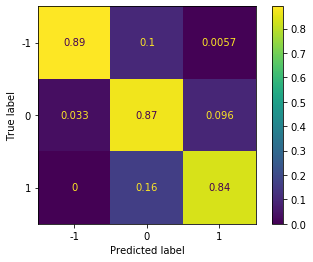

In [79]:
plot_confusion_matrix(mod2, X_test2, y_test2, normalize = 'true')
#we could see performance across -1,0,1 is now similar and at a good perc. 

In [80]:
print(classification_report(mod2.predict(X_test2), y_test2))

              precision    recall  f1-score   support

          -1       0.89      0.95      0.92       163
           0       0.87      0.81      0.84       259
           1       0.84      0.87      0.85       187

    accuracy                           0.87       609
   macro avg       0.87      0.88      0.87       609
weighted avg       0.87      0.87      0.86       609



In [81]:
accuracy_score(y_test2, mod2.predict(X_test2))

0.8653530377668309

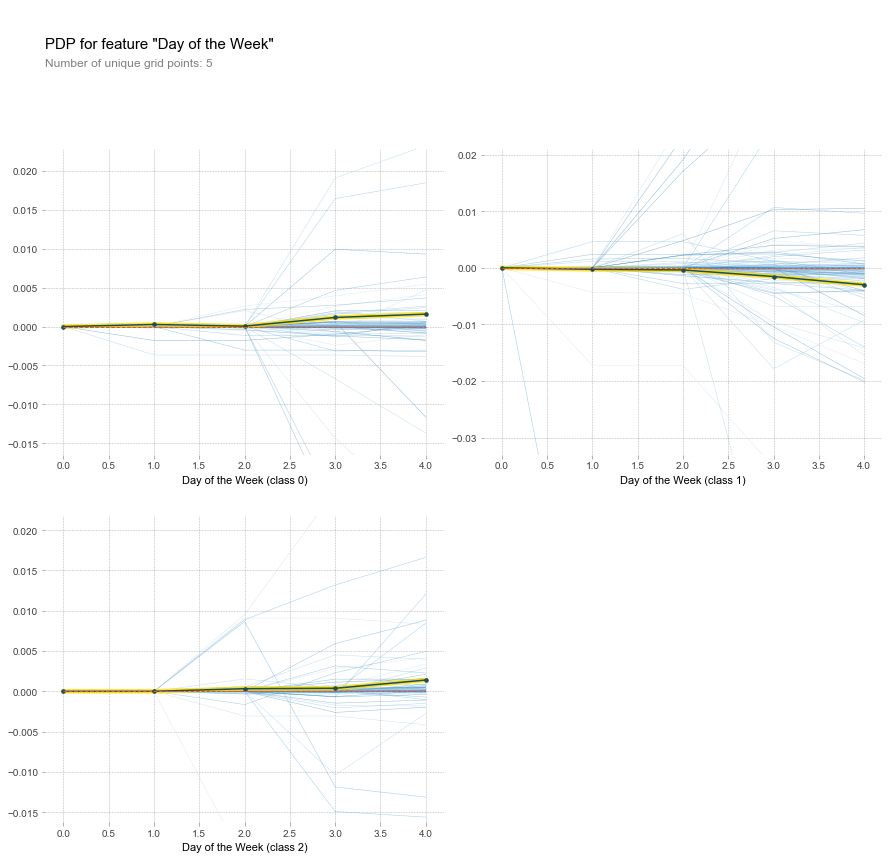

In [82]:
pdp_day_of_week = pdp.pdp_isolate(
    model=mod2, dataset=X_train2, model_features=X_train2.columns.tolist(), 
    feature='dow', cust_grid_points = X_train2['dow'].unique().tolist() # use this if you want to plot every unique value
)

fig, axes = pdp.pdp_plot(pdp_day_of_week, 'Day of the Week', plot_lines=True, frac_to_plot=100)
#looks like Tuesday and Wed tend to under-perform more than rest of the week